<a href="https://colab.research.google.com/github/dietmarja/LLM-Elements/blob/main/fine_tuning/fine_tuning_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine Tuning Including Visualization of Loss



In [ ]:
import torch
from torch import nn, optim
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
# @title
# Initialize the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Add a padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
    model.resize_token_embeddings(len(tokenizer))

In [ ]:
# Prepare the data (example using a dummy dataset)
train_texts = ["Example sentence one.", "Example sentence two."]
validation_texts = ["Validation sentence one.", "Validation sentence two."]
train_inputs = tokenizer(train_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
validation_inputs = tokenizer(validation_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)


In [ ]:
# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    for i in range(len(train_inputs["input_ids"])):
        input_ids = train_inputs["input_ids"][i].unsqueeze(0)
        attention_mask = train_inputs["attention_mask"][i].unsqueeze(0)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:  # Print loss every 10 batches
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")



Epoch: 0, Batch: 0, Loss: 7.710735321044922
Epoch: 1, Batch: 0, Loss: 3.258221387863159
Epoch: 2, Batch: 0, Loss: 1.6306072473526


In [ ]:
# Validation loop
model.eval()
val_loss = 0
with torch.no_grad():
    for i in range(len(validation_inputs["input_ids"])):
        input_ids = validation_inputs["input_ids"][i].unsqueeze(0)
        attention_mask = validation_inputs["attention_mask"][i].unsqueeze(0)
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        val_loss += outputs.loss.item()

avg_val_loss = val_loss / len(validation_inputs["input_ids"])
print(f"Epoch: {epoch}, Validation Loss: {avg_val_loss}")

Epoch: 2, Validation Loss: 5.413097381591797


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch: 0, Training Loss: 6.447508811950684, Validation Loss: 6.400969505310059
Epoch: 1, Training Loss: 2.856002688407898, Validation Loss: 4.5593156814575195
Epoch: 2, Training Loss: 0.9371308088302612, Validation Loss: 3.6952871084213257
Epoch: 0, Training Loss: 17.619080066680908, Validation Loss: 49.606855392456055
Epoch: 1, Training Loss: 26.86137866973877, Validation Loss: 40.51621437072754
Epoch: 2, Training Loss: 27.310802459716797, Validation Loss: 30.256832122802734
Epoch: 0, Training Loss: 63.885149002075195, Validation Loss: 26.580233573913574
Epoch: 1, Training Loss: 77.5512924194336, Validation Loss: 34.163103103637695
Epoch: 2, Training Loss: 3.051323175430298, Validation Loss: -15.053484439849854
Epoch: 0, Training Loss: 53.709786891937256, Validation Loss: 7.9738593101501465
Epoch: 1, Training Loss: 3.904714345932007, Validation Loss: 4.78881

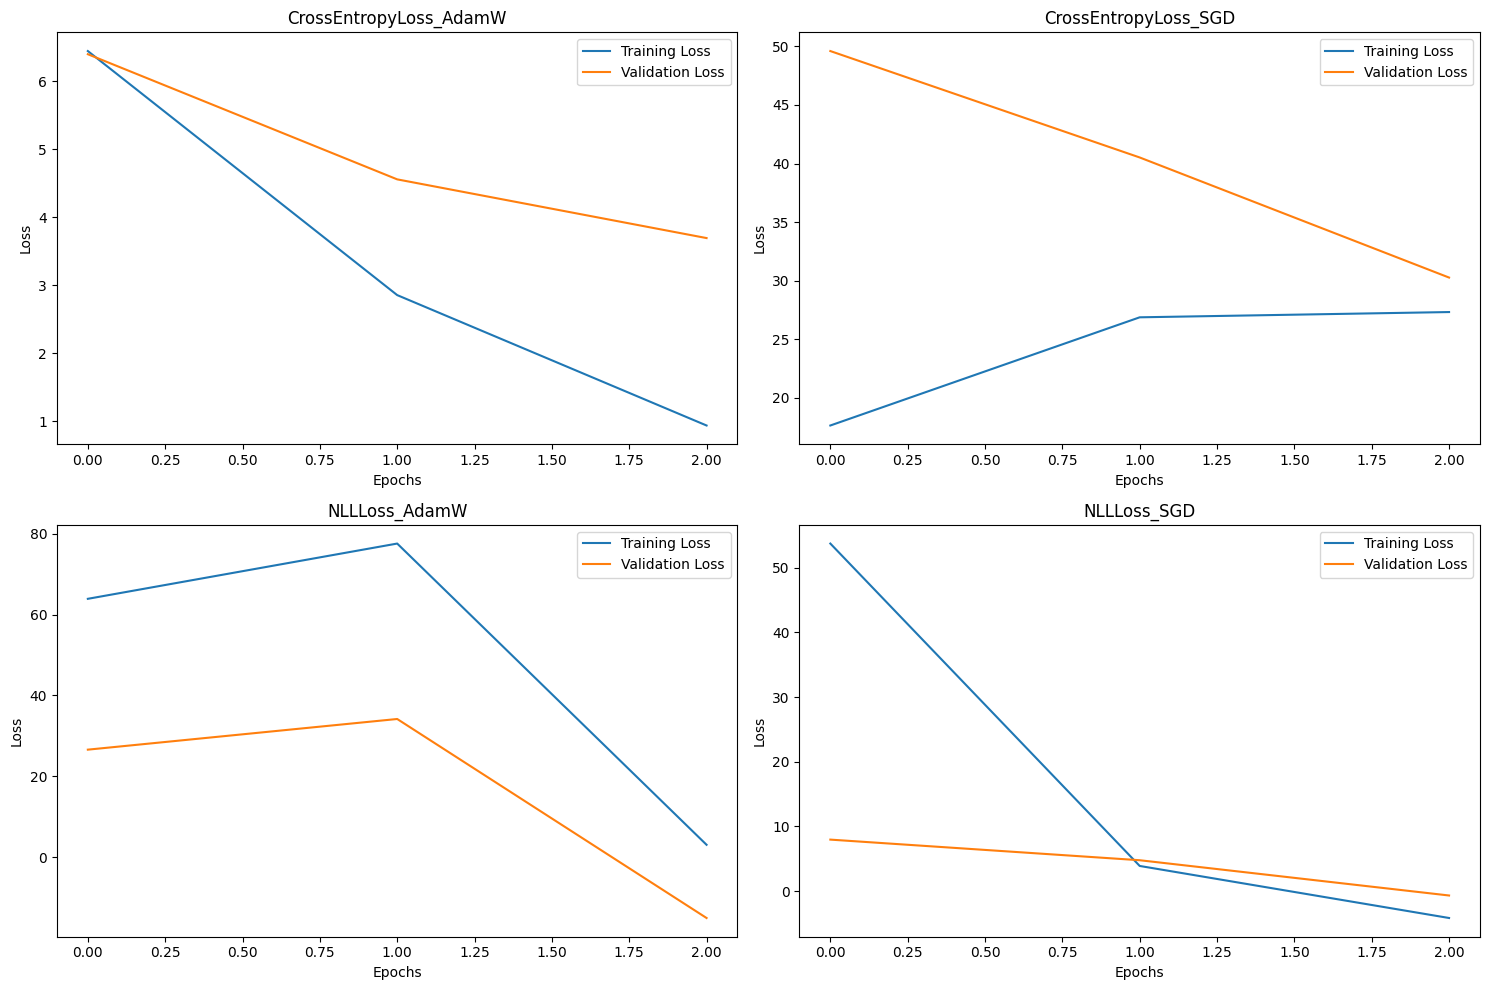

Sample output: Test sentence................................................
Training completed.


In [ ]:

import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from google.colab import drive

# Initialize the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

drive.mount('/content/drive')

# Add a padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
    model.resize_token_embeddings(len(tokenizer))

# Ensure the pad token ID is set for the model
model.config.pad_token_id = tokenizer.pad_token_id

# Prepare the data (example using a dummy dataset)
train_texts = ["Example sentence one.", "Example sentence two."]
validation_texts = ["Validation sentence one.", "Validation sentence two."]
train_inputs = tokenizer(train_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
validation_inputs = tokenizer(validation_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Define the loss functions and optimizers
loss_functions = {
    "CrossEntropyLoss": nn.CrossEntropyLoss(),
    "NLLLoss": nn.NLLLoss()
}
optimizers = {
    "AdamW": lambda params: optim.AdamW(params, lr=5e-5),
    "SGD": lambda params: optim.SGD(params, lr=0.01)
}

# Dictionary to store losses
all_losses = {
    "CrossEntropyLoss_AdamW": {"train": [], "val": []},
    "CrossEntropyLoss_SGD": {"train": [], "val": []},
    "NLLLoss_AdamW": {"train": [], "val": []},
    "NLLLoss_SGD": {"train": [], "val": []}
}

# Training configurations
epochs = 3

# Iterate over all combinations of loss functions and optimizers
for loss_name, loss_fn in loss_functions.items():
    for optim_name, optim_fn in optimizers.items():
        # Re-initialize the model and optimizer for each combination
        model = GPT2LMHeadModel.from_pretrained("gpt2")
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
            model.resize_token_embeddings(len(tokenizer))
        optimizer = optim_fn(model.parameters())

        # Ensure the pad token ID is set for the model
        model.config.pad_token_id = tokenizer.pad_token_id

        # Lists to store losses
        training_losses = []
        validation_losses = []

        # Training loop
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            for i in range(len(train_inputs["input_ids"])):
                input_ids = train_inputs["input_ids"][i].unsqueeze(0).to(model.device)
                attention_mask = train_inputs["attention_mask"][i].unsqueeze(0).to(model.device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
                logits = outputs.logits
                loss = loss_fn(logits.view(-1, logits.size(-1)), input_ids.view(-1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_inputs["input_ids"])
            training_losses.append(avg_train_loss)

            # Validation loop
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for i in range(len(validation_inputs["input_ids"])):
                    input_ids = validation_inputs["input_ids"][i].unsqueeze(0).to(model.device)
                    attention_mask = validation_inputs["attention_mask"][i].unsqueeze(0).to(model.device)

                    outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
                    logits = outputs.logits
                    val_loss += loss_fn(logits.view(-1, logits.size(-1)), input_ids.view(-1)).item()

            avg_val_loss = val_loss / len(validation_inputs["input_ids"])
            validation_losses.append(avg_val_loss)

            print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Store losses for plotting
        key = f"{loss_name}_{optim_name}"
        all_losses[key]["train"] = training_losses
        all_losses[key]["val"] = validation_losses

print("Training and validation completed.")

# Plot the losses
plt.figure(figsize=(15, 10))
for i, (key, losses) in enumerate(all_losses.items()):
    plt.subplot(2, 2, i+1)
    plt.plot(range(epochs), losses["train"], label='Training Loss')
    plt.plot(range(epochs), losses["val"], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(key)
    plt.legend()
plt.tight_layout()
plt.show()

# Generate sample output
model.eval()
with torch.no_grad():
    sample_output = model.generate(
        tokenizer.encode("Test sentence", return_tensors="pt").to(model.device),
        max_length=50,
        pad_token_id=tokenizer.pad_token_id,
        attention_mask=torch.ones_like(tokenizer.encode("Test sentence", return_tensors="pt"))
    )
    print(f"Sample output: {tokenizer.decode(sample_output[0], skip_special_tokens=True)}")

print("Training completed.")
